# Generate Features from documents

In [84]:
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
from collections import Counter
%matplotlib inline
plt.style.use("ggplot")
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Read Doc Corpus & chop into TFiDF-BOWs

In [5]:
df = pd.read_csv("../data/processed/data_train_test_imdb_ids.csv")
df_test, df_train = df[df["set"]=="test"], df[df["set"]=="train"]
train_review = df_train["review"].values
train_lbl = df_train["sentiment"].values
test_review = df_test["review"].values
test_lbl = df_test["sentiment"].values

### Naive Bayes Pipeline

In [14]:
# NAIVE-BAYES classification pipeline
pl_clf_jobs = Pipeline([('tfidf', TfidfVectorizer()),
                        ('clf', MultinomialNB()),
                       ])

# Parameter grid for hyper parameter tuning (of preprocessing)
param_grid = [{'tfidf__stop_words' : [None]}]


# create grid search
gs_clf_jobs = GridSearchCV(pl_clf_jobs,
                           param_grid=param_grid,
                           cv=10,
                           n_jobs=-1,
                           verbose=True
                          )

# run grid search
_ = gs_clf_jobs.fit(train_review, train_lbl)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.9s finished


In [15]:
nb = _.best_estimator_

In [8]:
nb.score(test_review, test_lbl)

0.8135

# Advanced Shit following

### To be tested
- min/max tfidf
- stemming
- stopwordremoval


# Custom stemmer/tokenizer

In [10]:
# Create a custom Porter Stemmer that suits sklearn
class PortStem(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        return [self.ps.stem(word) for word in word_tokenize(doc)]

In [21]:
# NAIVE-BAYES classification pipeline
pl_clf_jobs = Pipeline([('tfidf', TfidfVectorizer()),
                        ('clf', MultinomialNB()),
                       ])

# Parameter grid for hyper parameter tuning (of preprocessing)
param_grid = [{'tfidf__stop_words' : [None, "english"]},
              {'tfidf__tokenizer': [None, PortStem()]}
             ]



# create grid search
gs_clf_jobs = GridSearchCV(pl_clf_jobs,
                           param_grid=param_grid,
                           cv=2,
                           n_jobs=-1,
                           verbose=True
                          )

# run grid search
_ = gs_clf_jobs.fit(train_review, train_lbl)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.8s finished


In [192]:
nb = _.best_estimator_

In [193]:
nb.score(test_review, test_lbl)

0.8135

Other stemmer no improvement...

# KNN

In [11]:
# KNN classification pipeline
pl_clf_jobs = Pipeline([('tfidf', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier()),
                       ])

# Parameter grid for hyper parameter tuning (of preprocessing)
param_grid = [{'tfidf__stop_words' : [None]},
              {'tfidf__tokenizer': [None, PortStem()]},
              {'clf__n_neighbors': [190, 191, 192]},
              {'clf__metric': ['cosine']}
              
             ]



# create grid search
gs_clf_jobs = GridSearchCV(pl_clf_jobs,
                           param_grid=param_grid,
                           cv=2,
                           n_jobs=-1,
                           verbose=True
                          )

# run grid search
_ = gs_clf_jobs.fit(train_review, train_lbl)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   25.7s finished


In [12]:
knn = _.best_estimator_

In [13]:
knn.score(test_review, test_lbl)

0.76149999999999995

# Logistic Regression

In [329]:
# Logistic Regression classification pipeline
pl_clf_jobs_lr = Pipeline([('tfidf', TfidfVectorizer()),
                           ('clf', LogisticRegression()),
                          ])

# Parameter grid for hyper parameter tuning 
param_grid_lr = [{'tfidf__stop_words' : [None, 'english'],
                  'tfidf__tokenizer' : [None, PortStem()],
                  'clf__penalty' : ["l1", "l2"],
                  'clf__C' : [1.0, 10.0, 100.0,]
                 }]

# create grid search
gs_clf_jobs_lr = GridSearchCV(pl_clf_jobs_lr,
                              param_grid=param_grid_lr,
                              cv=2,
                              n_jobs=-1,
                              verbose=True
                              )

# run grid search
_ = gs_clf_jobs_lr.fit(train_review, train_lbl)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.5min finished


In [330]:
lr = _.best_estimator_

In [195]:
lr.score(test_review, test_lbl)

0.85199999999999998

In [450]:
miss_mask = lr.predict(test_review) != test_lbl

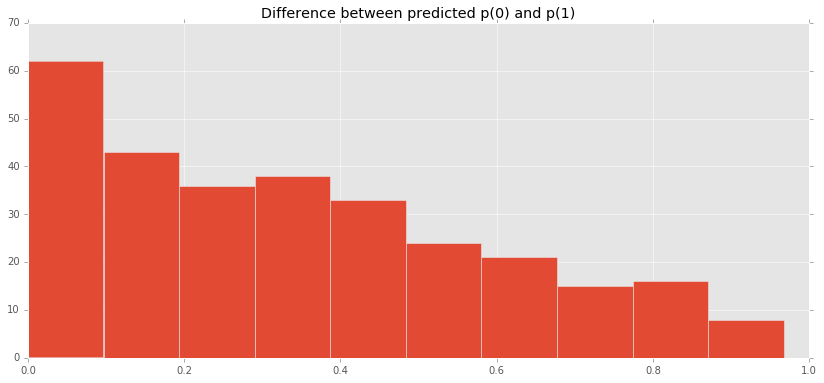

In [464]:
plt.hist(np.abs(
np.apply_along_axis(
    np.diff, 
    axis=1, 
    arr=lr.predict_proba(test_review[miss_mask]))
    )
)
plt.title("Difference between predicted p(0) and p(1)")
plt.show()

# Where to go from here?
- **combine word and genre** ("greatHORROR") >> get rid of sklearn pipeline to insert the append at the right position
- **ngrams** (e.g. 2-grams for "not bad", etc...)

### Loading tabular IMDB to merge w/ 'enhanced' test-train-set

In [381]:
df_imdb = pd.read_csv("../data/processed/IMDB.csv", delimiter=";")
df_test_train_en = pd.read_csv("../data/processed/data_train_test_imdb_ids.csv")

---
# Combine words and genre
1. preprocessing
2. stop word removal
3. stemming + tokenization
4. concatting with (e.g) genre

In [160]:
# retrieve relevant cols
df_imdb_genres = df_imdb.loc[:, ["imdbID", "genre"]]
# concat genres
df_imdb_genres = col_concatter(df_imdb_genres, column="genre", delimiter=", ")
# rename id col for merging
df_imdb_genres.columns = ["imdb_id", "genre"]
# merge that shit
df_imdb_merged = pd.merge(df_test_train_en, df_imdb_genres, on="imdb_id")
# cleaned reviews
df_imdb_merged_pp = port_stemming(
    stop_word_removal(stopwords.words("english"), 
                      df_imdb_merged
    )
)
# combined review and genre
df_imdb_merged_pp_concat = review_concatter(df_imdb_merged_pp)

In [804]:
# train test split
df_train = \
df_imdb_merged_pp_concat[df_imdb_merged_pp_concat["set"] == "train"]
df_test = \
df_imdb_merged_pp_concat[df_imdb_merged_pp_concat["set"] == "test"]
train_review = df_train["review"].values
train_lbl = df_train["sentiment"].values
test_review = df_test["review"].values
test_lbl = df_test["sentiment"].values

In [812]:
nb = MultinomialNB()

tfidf = TfidfVectorizer()
bow_train = tfidf.fit_transform(train_review)

nb.fit(bow_train, train_lbl)

bow_test = tfidf.transform(test_review)
nb.score(bow_test, test_lbl)

0.5

No improvement here, since the count of unique genre concats **is too damn high**

## Alternative
Merge only with most occurent Genre or other "set"-attribute (e.g. whereHORROR vs. whereNOHORROR)

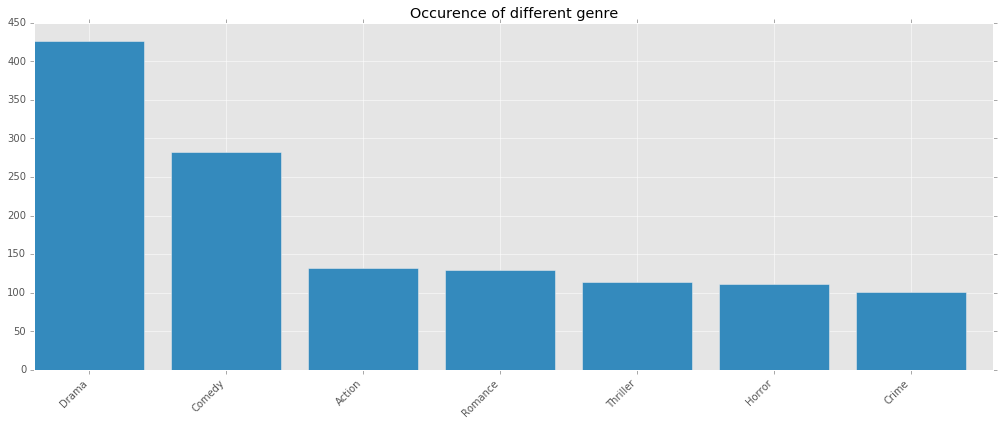

In [146]:
plot_occurency(df_imdb, column="genre", min_cnt=100)

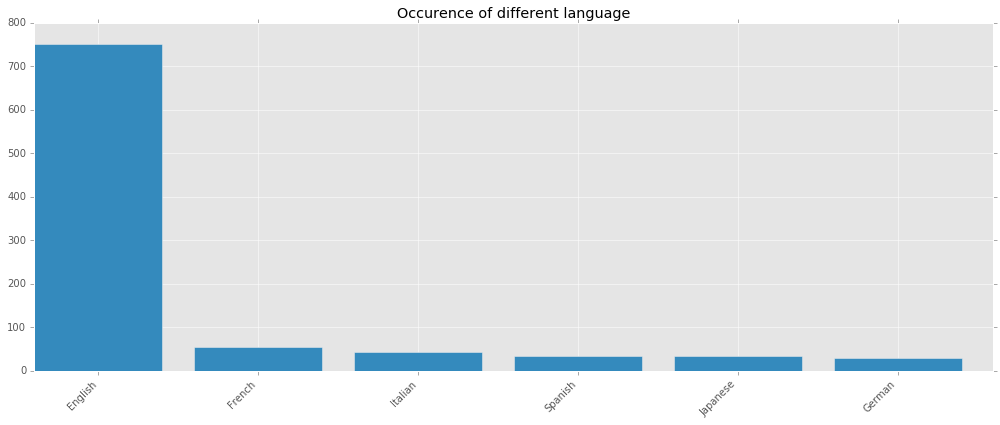

In [145]:
plot_occurency(df_imdb, column="language", min_cnt=20)

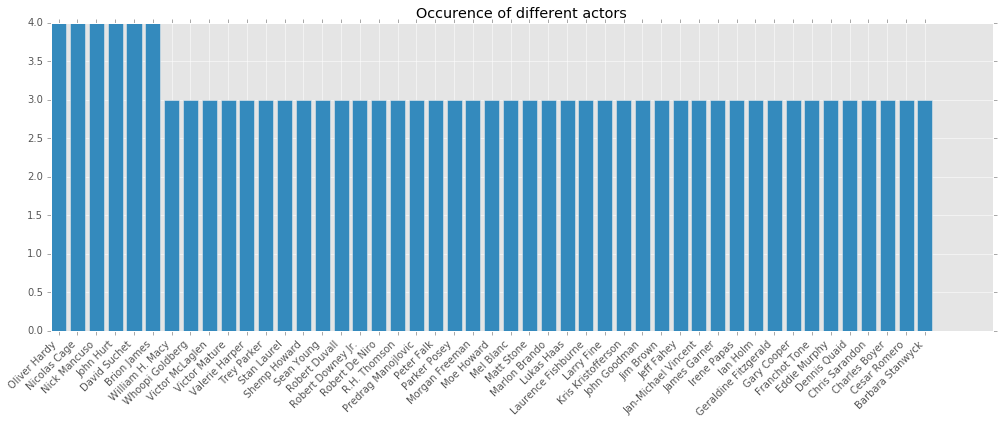

In [144]:
plot_occurency(df_imdb, column="actors", min_cnt=3)

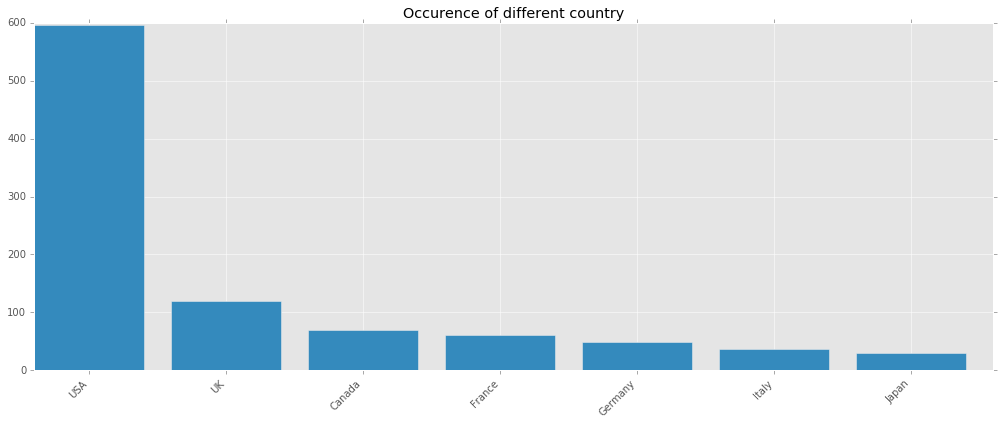

In [173]:
plot_occurency(df_imdb, column="country", min_cnt=20)

1. generate feature e.g. "horror" in "genre"
2. filter based on that feature
3. boxplot

*`plot_score_per_item(df, column, items=[])`*

In [366]:
# Merge raw imdb and review files
df_imdb_raw = df_imdb.copy()
df_imdb_raw.rename(columns={"imdbID":"imdb_id"}, inplace=True)
df_imdb_merged_raw = pd.merge(df_test_train_en, df_imdb_raw, on="imdb_id")

In [379]:
imdb_genre = df_imdb_raw.loc[:, ["imdb_id", "genre"]]

In [422]:
_  = pd.merge(imdb_genre, test_train_rating, on="imdb_id")["imdb_id"]

Viellecith sind die reviews für single label genres nicht dabei?

In [318]:
# get unique genres

In [436]:
df_imdb_merged_raw["year"].unique()

array(['2006', '1970', '1990', '2008'], dtype=object)

In [434]:
unique_items = [
    "Action", 
    "Adventure", 
    "Drama", 
    "Comedy", 
    "Musical", 
    "Romance", 
    "Crime"]

In [437]:
unique_year = ["2006", "1970", "1990", "2008"]

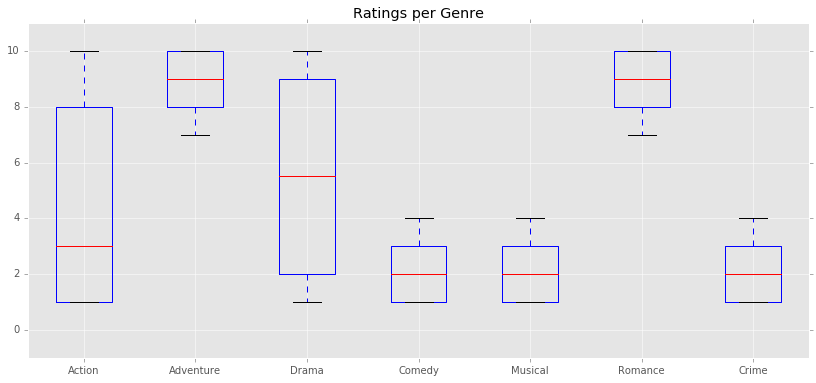

In [435]:
_ = plot_score_per_items(df_imdb_merged_raw, column="genre", items=unique_items)

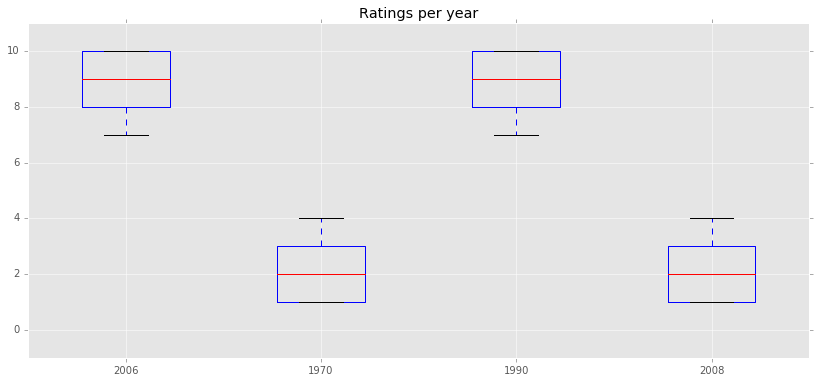

In [445]:
_ = plot_score_per_items(df_imdb_merged_raw, column="year", items=unique_year)

---
# N-grams

In [38]:
# to be continued

---
# Helper for preprocessing the docs manually

In [26]:
def preprocessor(text, lowercase=True):
    """Remove HTML-tags and digits
    """
    text = re.sub('<[^>]*>', '', text) # get rid of html tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove any non char
    text = re.sub(' +', ' ', text)
    if lowercase:
        text = text.lower()
    return text


def tokenizing(text):
    """Tokenizing word by word
    """
    return text.split()


def stop_word_removal(sw_list, df, column="review"):
    """Stopword removal including preprocessing
    """
    if not "review" in df.columns:
        raise ValueError("Need to have a 'review' column") 
    df_res = df.copy()  
    rev_new = df.apply(
        lambda row: 
        " ".join([word for word
                  in tokenizing(preprocessor(df[column][0]))
                  if word not in sw_list]), 
        axis=1)
    df_res[column] = rev_new
    return df_res


def port_stemming(df, column="review"):
    """Porter stemming for review column
    """
    if not "review" in df.columns:
        raise ValueError("Need to have a 'review' column")
    ps = PorterStemmer()
    df_res = df.copy()
    rev_new = df.apply(
        lambda row:
        " ".join([ps.stem(word) for word in row["review"].split()]),
        axis=1)
    df_res[column] = rev_new
    return df_res


def review_concatter(df, concat="genre"):
    """Append the 'concat' to each word of the review
    """
    if not "review" in df.columns:
        raise ValueError("Need to have a 'review' column")
    df_res = df.copy()
    rev_new = df.apply(
        lambda row:
        " ".join([word+row[concat] for word in row["review"].split()]),
        axis=1)
    df_res["review"] = rev_new
    return df_res


def col_concatter(df, column, delimiter=",", uppercase=True):
    """Concat multiple values of one column
    """
    df_res = df.copy()
    if uppercase:
        col_new = df.apply(
        lambda row: "" if type(row[column]) != str else \
        "".join(
            sorted(map(lambda x: x.upper(), row[column].split(delimiter)))
        ),axis=1)
    else:
        col_new = df.apply(
        lambda row:
        "".join(
            row[column].split(delimiter)
        ),axis=1)
    df_res[column] = col_new
    return df_res

--- 
# Helper for Histograms and Boxplots

In [142]:
def plot_occurency(df, column, delimiter=", ", min_cnt=1):
    # bring separated string to lists
    tmp = \
    df_imdb.apply(
        lambda row: 
        [] if type(row[column]) != str else 
        row[column].split(delimiter),
        axis=1
    )
    # derive counts
    counts =  Counter(np.concatenate(np.apply_along_axis(lambda x: x, axis=0, arr=tmp)))
    count_sets = [(counts[k], k) for k in counts.keys() if counts[k]>= min_cnt]
    count_sets.sort(reverse=True)
    # extract values for plot
    values = list(zip(*count_sets))[0]
    labels  = list(zip(*count_sets))[1]
    plt.rcParams["figure.figsize"] = [14, 6]
    h = plt.bar(range(len(values)), values)
    plt.title("Occurence of different {}".format(column))
    xticks_pos = [0.5*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, labels, ha="right", rotation=45, )
    plt.tight_layout()
    plt.show()
    return 

/Users/joshuagorner/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


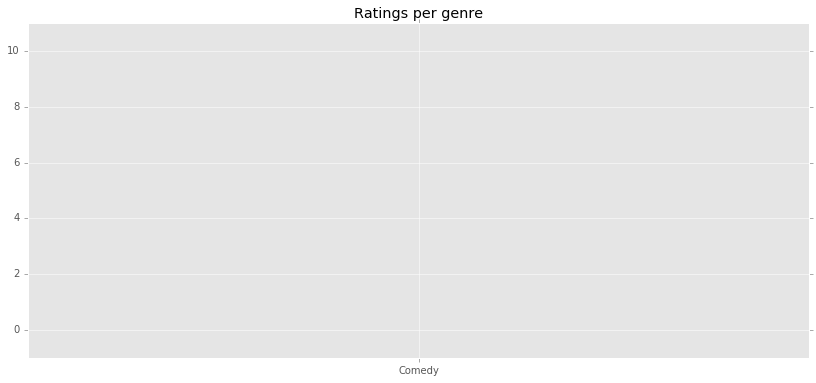

In [444]:
def plot_score_per_items(df, column, items, col_score="rating", col_id="imdb_id", delimiter=", "):
    #tmp = df.copy()
    tmp = df.loc[:, [col_id, col_score, column]].copy()
    # convert strings to sets
    tmp[column] =\
    tmp.apply(
        lambda row: 
        frozenset([]) if type(row[column]) != str else 
        frozenset(row[column].split(delimiter)),
        axis=1
    )
    # items in column
    box_data = []
    box_cols = []
    for i in items:
        contained=\
        tmp.apply(
        lambda row: i in row[column],
            axis=1
        )
        tmp[column + "_" + i] = contained
        box_data.append(tmp[tmp[column + "_" + i]][col_score].values)
        box_cols.append(i)
    plt.boxplot(box_data)
    plt.ylim(-1, 11)
    plt.xticks(range(1,len(box_cols)+1),box_cols)
    plt.title("Ratings per {}".format(column))
    return tmp
_ = plot_score_per_items(test, column="genre", items=["Comedy"])

In [443]:
test

,﻿response,title,year,rated,released,runtime,genre,director,writer,actors,...,awards,poster,metascore,imdbRating,imdbVotes,imdbID,type,season,episode,seriesID
51,True,Saps at Sea,1940,APPROVED,03 May 1940,57 min,Comedy,Gordon Douglas,"Charley Rogers (original story), Felix Adler (...","Stan Laurel, Oliver Hardy, James Finlayson, Be...",...,NaN,http://ia.media-imdb.com/images/M/MV5BMjE5MTc0...,NaN,"7,2","1,700",tt0033022,movie,NaN,NaN,NaN
74,True,"Once More, My Darling",1949,S,24 Jun 1950,1 h 32 min,Comedy,Robert Montgomery,"Robert Carson, Robert Carson","Robert Montgomery, Ann Blyth, Jane Cowl, Charl...",...,NaN,NaN,NaN,"6,7",65,tt0041717,movie,NaN,NaN,NaN
76,True,Utopia,1951,NaN,14 Dec 1954,82 min,Comedy,"Léo Joannon, John Berry, Alfred J. Goulding, T...","Monte Collins (additional material), Léo Joann...","Stan Laurel, Oliver Hardy, Suzy Delair, Max Elloy",...,NaN,http://ia.media-imdb.com/images/M/MV5BMjEyMDIx...,NaN,"5,6","1,297",tt0042210,movie,NaN,NaN,NaN
95,True,Mister Scoutmaster,1953,APPROVED,02 Sep 1953,87 min,Comedy,Henry Levin,"Rice E. Cochran (novel), Leonard Praskins (scr...","Clifton Webb, Edmund Gwenn, George Winslow, Fr...",...,NaN,http://ia.media-imdb.com/images/M/MV5BODMzNDAy...,NaN,"6,9",234,tt0046081,movie,NaN,NaN,NaN
124,True,Man in a Cocked Hat,1959,NaN,11 Apr 1960,88 min,Comedy,"Roy Boulting, Jeffrey Dell","Jeffrey Dell (original story), Roy Boulting (o...","Terry-Thomas, Peter Sellers, Luciana Paluzzi, ...",...,NaN,http://ia.media-imdb.com/images/M/MV5BMjEzOTAy...,NaN,"6,4",557,tt0053044,movie,NaN,NaN,NaN
129,True,The Tiger Makes Out,1967,NaN,16 Mar 1970,94 min,Comedy,Arthur Hiller,"Murray Schisgal (play), Murray Schisgal (scree...","Eli Wallach, Anne Jackson, Bob Dishy, John Har...",...,NaN,NaN,NaN,"5,9",176,tt0062369,movie,NaN,NaN,NaN
138,True,Futz,1969,NOT RATED,16 Nov 1969,92 min,Comedy,Tom O'Horgan,"Rochelle Owens (play), Joseph Stefano (screenp...","Seth Allen, John Bakos, Mari-Claire Charba, Pe...",...,NaN,NaN,NaN,"4,8",50,tt0064354,movie,NaN,NaN,NaN
140,True,Putney Swope,1969,R,10 Jul 1969,84 min,Comedy,Robert Downey Sr.,Robert Downey Sr.,"Stan Gottlieb, Allen Garfield, Archie Russell,...",...,NaN,http://ia.media-imdb.com/images/M/MV5BMTIwMjg4...,NaN,"6,9","1,897",tt0064855,movie,NaN,NaN,NaN
163,True,Where Does It Hurt?,1972,R,24 Jul 1972,87 min,Comedy,Rod Amateau,"Rod Amateau (novel), Budd Robinson (novel), Ro...","Peter Sellers, Jo Ann Pflug, Rick Lenz, Harold...",...,NaN,http://ia.media-imdb.com/images/M/MV5BMTc1Mjg2...,NaN,"5,7",302,tt0069497,movie,NaN,NaN,NaN
170,True,The Top Secret Life of Edgar Briggs,1974–,NaN,15 Sep 1974,30 min,Comedy,NaN,NaN,"David Jason, David Webb, Noel Coleman, Michael...",...,NaN,NaN,NaN,"8,6",29,tt0071068,series,NaN,NaN,NaN
